>**Update: I've moved the code from this post, along with resources for designing mouse tracking experiments, and some example data, to [a GitHub repository](https://github.com/EoinTravers/QuickstartMousetracking). The best way to learn how to use squeak is to play around with this repository, which also includes the content of this post.**

A while ago, I gathered up the python code I've been using to process mouse trajectory data
into a package and gave it the jaunty title [squeak](http://github.io/eointravers/squeak).
However, as this was mostly for my own use, I never got around to properly documenting it.

Recently, a few people have asked me for advice on analysing mouse data not collected using [MouseTracker](http://www.mousetracker.org/) - for instance, data generated using [my OpenSesame implementation](http://eointravers.github.io/blog/2014/03/os-mousetracking/). In response, I've gone through a full example for this post, and written a script that should be able to preprocess any data collected using my OpenSesame implementation. To use any of this, you'll need to have the python language installed, along with some specific scientific packages, and of course squeak itself, which is available using the `pip` command:

`pip install squeak`

In this post, I go through the code bit by bit, explaining what specifically is going on.
If you're not used to using python, you don't have to worry to much about understanding all of the syntax,
although python is relatively easy to read as if it was plain English. The full, downloadable script is included at the bottom of the page.

---

# Data Processing

In [1]:
# For reading data files
import os 
import glob

import numpy as np # Numeric calculation
import pandas as pd # General purpose data analysis library
import squeak # For mouse data

# For plotting
import matplotlib.pyplot as plt 
%matplotlib inline
# Prettier default settings for plots (optional)
import seaborn
seaborn.set_style('darkgrid')
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

First, we need to load our data.
I'll show how to do this using the .csv files saved by OpenSesame,
as this gives us a chance to see how you can use squeak to handle
trajectory data that's been saved in this exchangable format.

We can combine all of our files into a single data structure
by reading them one at a time, using `pd.read_csv`,
storing them in a list,
and then merging this list using `pd.concat`.

In [2]:
results = []
for datafile in glob.glob('data/*.csv'):
    this_data = pd.read_csv(datafile)
    results.append(this_data)
data = pd.concat(results)

A faster and more concise alternative, using python's list comprehension abilities, would look like this instead:

In [3]:
data = pd.concat(
    [pd.DataFrame(pd.read_csv(datafile)) 
     for datafile in glob.glob('data/*.csv')])

Either way, we end up with data in the form shown below.

In [4]:
print data.head()

   accuracy condition  count_trial_sequence  height                 probe  \
0         1       lie                     0    1080    Nighttime is sunny   
1         1     truth                     1    1080   Humans have 2 hands   
2         1     truth                     2    1080           Ice is cold   
3         1       lie                     3    1080          Water is dry   
4         0       lie                     4    1080  Elephants are purple   

   response    rt  subject_nr  \
0         2   977         105   
1         1   848         105   
2         1  1141         105   
3         2   913         105   
4         1   759         105   

                                         tTrajectory  width  \
0  [31, 61, 91, 121, 151, 181, 211, 241, 271, 301...   1920   
1  [31, 61, 91, 121, 151, 181, 211, 241, 271, 301...   1920   
2  [31, 61, 91, 121, 151, 181, 211, 241, 271, 301...   1920   
3  [31, 61, 91, 121, 151, 181, 211, 241, 271, 301...   1920   
4  [31, 61, 91, 121, 15

As you can see, there's one row per trial,
and each of the coding variables we recorded in OpenSesame occupy a single column.

The trajectory data, though, is stored in three columns, 
"tTrajectory",
"xTrajectory",
and  "yTrajectory",
corresponding to time elapsed, x-axis position, and y-axis position, respectively.
Each cell here actually contains a string representation of the list of values in each case, in the form

    "[time1, time2, time3, ..., timeN]"

We can parse these using squeak's `list_from_string` function.

In [5]:
data['t'] = data.tTrajectory.map(squeak.list_from_string)
data['x'] = data.xTrajectory.map(squeak.list_from_string)
data['y'] = data.yTrajectory.map(squeak.list_from_string)

At this stage, we have our data in a format python can understand, and it looks like this.

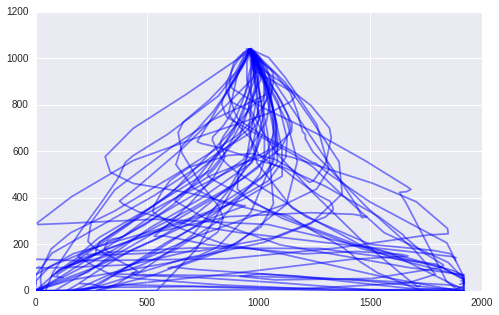

In [6]:
for i in range(len(data)):
    x = data.x.iloc[i]
    y = data.y.iloc[i]
    plt.plot(x, y, color='blue', alpha=.5) # alpha controlls the transparency
plt.show()

We still need to do some preprocessing of the trajectories - OpenSesame logs y-axis coordinates upside down from what we would want, and more importantly, it's conventional to standardise trajectories so they start at [0,0] and end at [1,1.5], and to flip the trials where the left hand side response was chosen the other way around for comparison. Let's do that now.

In [7]:
data['y'] = data.y * -1 # Reverse y axis
data['x'] = data.x.map(squeak.remap_right) # Flip the leftward responses
data['x'] = data.x.map(squeak.normalize_space)
data['y'] = data.y.map(squeak.normalize_space) * 1.5

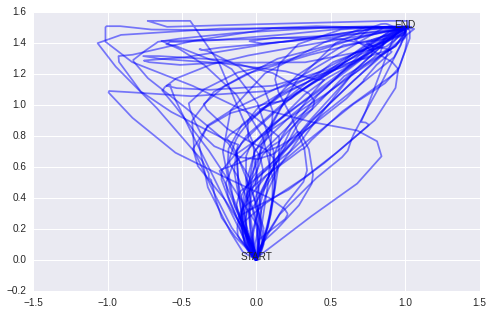

In [8]:
for i in range(len(data)):
    x = data.x.iloc[i]
    y = data.y.iloc[i]
    plt.plot(x, y, color='blue', alpha=.5)
plt.text(0, 0, 'START', horizontalalignment='center')
plt.text(1, 1.5, 'END', horizontalalignment='center')
plt.show()

Our next problem as that all of our trials last for different amounts of time.

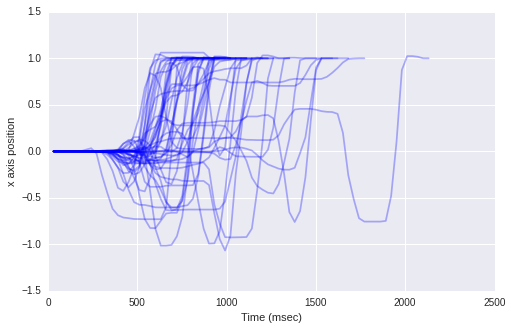

In [9]:
for i in range(len(data)):
    x = data.x.iloc[i]
    t = data.t.iloc[i]
    plt.plot(t, x, color='blue', alpha=.3)
plt.xlabel('Time (msec)')
plt.ylabel('x axis position')
plt.show()

We can deal with this in one of two ways, both of which I'll demonstrate.

Most analyses standardize the trajectories into 101 time slices, for comparison,
meaning that for every trajectory, sample 50 is halfway through, regardless of how long that actually takes.
(the code looks a little intimidating, and future versions of squeak should include a more concise way of doing this. You don't need to worry too much about what's happening here).

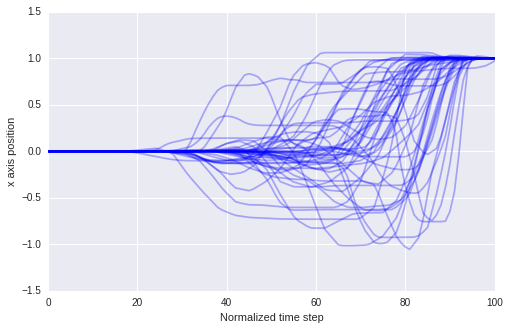

In [10]:
data['nx'], data['ny'] = zip(*[squeak.even_time_steps(x, y, t) for x, y, t, in zip(data.x, data.y, data.t)])

for i, x in data.nx.iteritems():
    plt.plot(x, color='blue', alpha=.3)
plt.xlabel('Normalized time step')
plt.ylabel('x axis position')
plt.show()

An alternative approach is to keep the actual timestamp for each sample, so you can analyse the development of the trajectories in real time. To do this, you need to "*extend*" the data for all of the trials so that they all last for the same amount of time. In this example, we'll extend every trial to 5 seconds (5000 milliseconds).

This can be done by treating all of the time *after* the participant has clicked on their response as if they instead just kept the cursor right on top of the response until they reach 5 seconds. Again, you can copy this code literally, so don't worry about the details of the syntax here.

In [11]:
max_time = 5000 # Alternatively, max_time = data.rt.max()
data['rx'] = [squeak.uniform_time(x, t, max_duration=5000) for x, t in zip(data.x, data.t)]
data['ry'] = [squeak.uniform_time(y, t, max_duration=5000) for y, t in zip(data.y, data.t)] 

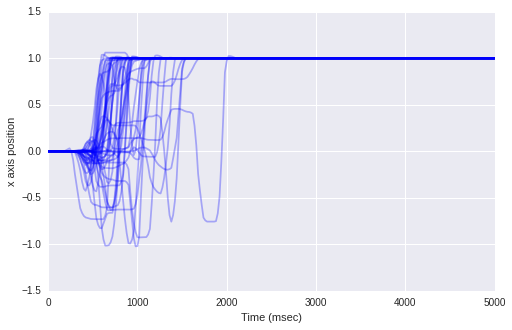

In [12]:
for i in range(len(data)):
    x = data.rx.iloc[i]
    plt.plot(x.index, x, color='blue', alpha=.3)
plt.xlabel('Time (msec)')
plt.ylabel('x axis position')
plt.show()

With all of this done, you're ready to calculate the statistics you'll be using in your analyses. Again, don't worry too much about the syntax here.

The most popular measures, calculated here, are:

- Maximum Deviation (MD): The size of the largest distance achieved between the actual trajectory and what it would have looked like if it was perfectly straight.
- Area Under the Curve (AUC): The area bounded between the trajectory and the ideal straight line path
- X-flips: changes of direction on the x axis
- Initiation time: The time taken for the participant to start moving the cursor.

In [13]:
# Mouse Stats
data['md'] = data.apply(lambda trial: squeak.max_deviation(trial['nx'], trial['ny']), axis=1)
data['auc'] = data.apply(lambda trial: squeak.auc(trial['nx'], trial['ny']), axis=1)
data['xflips'] = data.nx.map(squeak.count_x_flips)
data['init_time'] = data.ry.map(lambda y: y.index[np.where(y > .05)][0])

In [14]:
# Taking a look at condition means
print data.groupby('condition')['md', 'auc', 'xflips', 'init_time', 'rt'].mean()

                 md       auc    xflips  init_time           rt
condition                                                      
lie        0.897173  0.623391  1.000000      437.5  1185.458333
truth      0.512142  0.464115  0.708333      472.5  1056.208333

[2 rows x 5 columns]


Finally, we'll save our processed data. First, we split of our processed mouse trajectory columns into seperate data structures, which I'll explore a little more below.

The normalized time data are labelled `nx` and `ny`, and are formatted so that each row corresponds to a single trial, and each column is a time point, from 0 to 101. The real time data, `rx` and `ry`, are structured analagously, with each column corresponding to a timestamp. By default, these are broken up into 20 msec intervals, and the column headings (20, 40, 60, etc) reflect the actual timestamp.

In [15]:
nx = pd.concat(list(data.nx), axis=1).T
ny = pd.concat(list(data.ny), axis=1).T

rx = pd.concat(list(data.rx), axis=1).T
ry = pd.concat(list(data.ry), axis=1).T

With that done, we can delete this information from our main data frame, so that it's compact enough to use easily in your data analysis package of choice, before finally saving everything as csv files.

In [16]:
redundant = ['xTrajectory', 'yTrajectory', 'tTrajectory',
             'x', 'y', 't', 'nx', 'ny', 'rx', 'ry']
data = data.drop(redundant, axis=1)

data.head()

,accuracy,condition,count_trial_sequence,height,probe,response,rt,subject_nr,width,md,auc,xflips,init_time
0,1,lie,0,1080,Nighttime is sunny,2,977,105,1920,1.402258,1.162501,2,380
1,1,truth,1,1080,Humans have 2 hands,1,848,105,1920,0.297266,0.251029,0,380
2,1,truth,2,1080,Ice is cold,1,1141,105,1920,0.239202,0.000615,3,420
3,1,lie,3,1080,Water is dry,2,913,105,1920,0.751566,0.703262,1,320
4,0,lie,4,1080,Elephants are purple,1,759,105,1920,0.752111,0.808519,2,360


In [17]:
# Save data
data.to_csv('processed.csv', index=False)
nx.to_csv('nx.csv', index=False)
ny.to_csv('ny.csv', index=False)
rx.to_csv('rx.csv', index=False)
ry.to_csv('ry.csv', index=False)

The commands in full, minus the unnecessary plotting commands,
is below.
You can also download it as a script for running on your own data [here]().
To use it, you'll need to have python installed, along with the [SciPy scientific library for python](http://www.scipy.org/).
You should have your files arranged to that 
the script is in the main folder
(i.e. `C:\username\Desktop\MyResults`),
and your .csv files in a folder within that called `data`
(`C:\username\Desktop\MyResults\data`),
although obviously you can change this.

 

```python
#!/usr/bin/env python
import os 
import glob

try:
    import numpy as np # Numeric calculation
    import pandas as pd # General purpose data analysis library
    import squeak # For mouse data
except:
    raise Exception("\
Whoops, you're missing some of the dependencies you need to run this script.\n\
You need to have numpy, pandas, and squeak installed.")

this_dir = os.path.abspath('.')
print "Running in %s\n\
Checking for .csv files in %s" % (this_dir, os.path.join(this_dir, 'data'))

datafiles = glob.glob('data/*.csv')
print "%i files found:" % len(datafiles)
print '\n'.join(datafiles)


print "\nProcessing..."
data = pd.concat(
    [pd.DataFrame(pd.read_csv(datafile)) 
     for datafile in datafiles])

data['t'] = data.tTrajectory.map(squeak.list_from_string)
data['x'] = data.xTrajectory.map(squeak.list_from_string)
data['y'] = data.yTrajectory.map(squeak.list_from_string)

data['y'] = data.y * -1 # Reverse y axis
data['x'] = data.x.map(squeak.remap_right) # Flip the leftward responses
data['x'] = data.x.map(squeak.normalize_space)
data['y'] = data.y.map(squeak.normalize_space) * 1.5


# Normalized time
data['nx'], data['ny'] = zip(*[squeak.even_time_steps(x, y, t) 
                               for x, y, t, in zip(data.x, data.y, data.t)])

# Real time
max_time = 5000 # Alternatively, max_time = data.rt.max()
data['rx'] = [squeak.uniform_time(x, t, max_duration=5000) for x, t in zip(data.x, data.t)]
data['ry'] = [squeak.uniform_time(y, t, max_duration=5000) for y, t in zip(data.y, data.t)] 

# Mouse Stats
data['md'] = data.apply(lambda trial: squeak.max_deviation(trial['nx'], trial['ny']), axis=1)
data['auc'] = data.apply(lambda trial: squeak.auc(trial['nx'], trial['ny']), axis=1)
data['xflips'] = data.nx.map(squeak.count_x_flips)
data['init_time'] = data.ry.map(lambda y: y.index[np.where(y > .05)][0])


# Seperate data frames
nx = pd.concat(list(data.nx), axis=1).T
ny = pd.concat(list(data.ny), axis=1).T

rx = pd.concat(list(data.rx), axis=1).T
ry = pd.concat(list(data.ry), axis=1).T

redundant = ['xTrajectory', 'yTrajectory', 'tTrajectory',
             'x', 'y', 't', 'nx', 'ny', 'rx', 'ry']
data = data.drop(redundant, axis=1)

print "Done!\n"

# Save data
data.to_csv('processed.csv', index=False)
print "Summary statistics saved to %s" % os.path.join(this_dir, 'processed.csv')
nx.to_csv('nx.csv', index=False)
ny.to_csv('ny.csv', index=False)
rx.to_csv('rx.csv', index=False)
ry.to_csv('ry.csv', index=False)

for n in ['nx', 'ny', 'rx', 'ry']:
    print "Mouse trajectories saved to %s.csv" % os.path.join(this_dir, n)
```